In [2]:
# Add parent directory to python path (needed for modules imports from src)
import sys
import os
sys.path.append(os.path.join(os.getcwd(), '..'))

# Reload modules when code is changed (uncomment for development)
%load_ext autoreload
%autoreload 2

# Import modules
from src.matches import get_all_match_ids, load_all_events
from src.dribbles import get_all_dribbles
from src.basic_stats import calculate_goals_assists, calculate_shots_xg
from src.dribble_stats import calculate_dribble_stats, calculate_danger_dribble_stats
from src.player_info import get_player_positions, get_player_info
from src.playing_time import calculate_period_lengths, get_substitution_events, get_red_card_events, calculate_playing_time_single_match, calculate_playing_time
from src.player_stats import calculate_player_stats
from src.data_plots import filter_players_by_position, calculate_radar_plot_data
from src.radar_plot import create_radar_plot

from mplsoccer import Sbopen
parser = Sbopen()

# Get all match events

We'll combine all events from all matches in one dataframe that can be used to calculate the player stats.

In [5]:
# Example usage
match_ids = get_all_match_ids(competition_id=55, season_id=282)

In [31]:
match_ids[0:10]

[3942819,
 3943043,
 3942752,
 3942382,
 3942349,
 3930180,
 3930171,
 3942227,
 3942226,
 3938645]

In [32]:
# Example usage load all events
df_all_events = load_all_events(match_ids)

In [33]:
df_all_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187858 entries, 0 to 187857
Data columns (total 87 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              187858 non-null  object 
 1   index                           187858 non-null  int64  
 2   period                          187858 non-null  int64  
 3   timestamp                       187858 non-null  object 
 4   minute                          187858 non-null  int64  
 5   second                          187858 non-null  int64  
 6   possession                      187858 non-null  int64  
 7   duration                        136240 non-null  float64
 8   match_id                        187858 non-null  int64  
 9   type_id                         187858 non-null  int64  
 10  type_name                       187858 non-null  object 
 11  possession_team_id              187858 non-null  int64  
 12  possession_team_

# Calculate basic stats

Some stats that are nice to know even though there's not really about dribbling: goals, assists, shots and xG.

## Goals and assists

In [34]:
# Example usage
df_example = calculate_goals_assists(df_all_events)

In [35]:
df_example.sort_values(by="goals", ascending=False).head(10)

,player_id,goals,assists
98,33234.0,3,1
62,10955.0,3,0
74,16532.0,3,2
78,20750.0,3,1
89,28032.0,3,0
103,39565.0,3,0
24,5545.0,2,0
54,8966.0,2,1
70,15582.0,2,0
73,16344.0,2,0


## Calculate shots and total xG

In [36]:
# Usage example
df_example = calculate_shots_xg(df_all_events)
df_example.head(10)

,player_id,shots,shots_xg
0,2954.0,4,0.153319
1,2972.0,12,1.178654
2,2988.0,18,1.951101
3,3009.0,24,2.506847
4,3026.0,3,0.262040
5,3042.0,3,0.326048
6,3043.0,12,0.835043
7,3053.0,7,0.282124
8,3076.0,3,0.323953
9,3077.0,1,0.104913


# Calculate dribble stats

We're looking into dribbles for the case study so we need to filter down all events to the dribbles. We'll also indicate danger dribbles and add their respective xG.

## Get dribbles

In [37]:
df_dribbles = get_all_dribbles(match_ids, df_all_events)

df_dribbles.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1280 entries, 89 to 187651
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   match_id         1280 non-null   int64  
 1   type_name        1280 non-null   object 
 2   player_id        1280 non-null   float64
 3   outcome_name     1280 non-null   object 
 4   x                1280 non-null   float64
 5   y                1280 non-null   float64
 6   danger_dribble   1280 non-null   bool   
 7   xg_from_dribble  1280 non-null   float64
 8   dribble_to_goal  1280 non-null   bool   
dtypes: bool(2), float64(4), int64(1), object(2)
memory usage: 82.5+ KB


In [38]:
df_dribbles["danger_dribble"].value_counts()

danger_dribble
False    1132
True      148
Name: count, dtype: int64

## Calculate dribble stats

Completed, failed, total dribbles and success rate

In [39]:
# Example usage
df_example = calculate_dribble_stats(df_dribbles)
df_example.head()

outcome_name,player_id,completed_dribbles,failed_dribbles,attempted_dribbles,dribble_success_rate
0,2972.0,1,2,3,0.333333
1,2988.0,5,6,11,0.454545
2,3009.0,18,10,28,0.642857
3,3026.0,4,1,5,0.800000
4,3042.0,1,1,2,0.500000


## Calculate danger dribble stats

Danger dribbles end in a shot on goal within a certain timeframe (for example 15 seconds)

In [40]:
# Example usage
df_example = calculate_danger_dribble_stats(df_dribbles)
df_example.sort_values(by='danger_dribbles', ascending=False).head(10)

,player_id,danger_dribbles,danger_dribbles_xg,dribbles_to_goals,xg_per_danger_dribble
1,3009.0,7,0.340261,0,0.048609
45,23650.0,7,0.853821,0,0.121974
84,316046.0,4,0.391370,0,0.097843
11,5477.0,4,0.269036,0,0.067259
40,20750.0,4,0.546194,1,0.136549
15,6704.0,4,0.313539,0,0.078385
33,15582.0,4,0.522574,1,0.130644
5,3089.0,4,0.300362,0,0.075091
78,68574.0,4,0.537470,1,0.134368
19,7005.0,3,0.239840,0,0.079947


# Get player info

The events have the full player name as a value but we want the short name in our visualisations

In [41]:
# Get lineups info for a game
test = parser.lineup(3942819)
test.head()

,player_id,player_name,player_nickname,jersey_number,match_id,team_id,team_name,country_id,country_name
0,2988,Memphis Depay,Memphis Depay,10,3942819,941,Netherlands,160,Netherlands
1,3306,Nathan Aké,Nathan Aké,5,3942819,941,Netherlands,160,Netherlands
2,3311,Daley Blind,Daley Blind,17,3942819,941,Netherlands,160,Netherlands
3,3567,Georginio Wijnaldum,Georginio Wijnaldum,8,3942819,941,Netherlands,160,Netherlands
4,3669,Virgil van Dijk,Virgil van Dijk,4,3942819,941,Netherlands,160,Netherlands


In [6]:
# Example usage
df_example = get_player_positions(3942819)
df_example.head()

,player_id,positions
0,2988.0,{23: 34}
1,3205.0,{3: 189}
2,3244.0,{4: 249}
3,3306.0,{6: 121}
4,3308.0,{8: 112}


In [14]:
# Example usage
df_example = get_player_info(match_ids)
df_example.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 621 entries, 0 to 620
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   player_id          621 non-null    int64 
 1   player_name        621 non-null    object
 2   player_short_name  621 non-null    object
 3   team_name          621 non-null    object
 4   position           621 non-null    object
dtypes: int64(1), object(4)
memory usage: 24.4+ KB


In [12]:
df_example[df_example["team_name"] == "Spain"].head()

,player_id,player_name,player_short_name,team_name,position
6,3042,Mikel Merino Zazón,Mikel Merino,Spain,midfielder
9,3076,Ayoze Pérez Gutiérrez,Ayoze Pérez,Spain,forward
19,3265,José Luis Sanmartín Mato,Joselu,Spain,forward
30,3477,Álvaro Borja Morata Martín,Álvaro Morata,Spain,forward
55,4127,David Raya Martin,David Raya,Spain,keeper


In [15]:
df_example["position"].value_counts()

position
forward       176
defender      167
dnp           130
midfielder    119
keeper         29
Name: count, dtype: int64

# Calculate playing time

There's no data included from StatsBomb that shows the playing time of players so we'll have to calculate it ourselves

## Calculate period lengths

In [46]:
# Example usage
test_game = parser.event(3942227)[0]
df_example = calculate_period_lengths(test_game)
df_example.head()

,period,length,additional_time,minutes_played,seconds_played,game_minute,game_second
0,1,2706,6,45,6,45,6
1,2,2876,176,47,56,92,56
2,3,900,0,15,0,105,0
3,4,967,67,16,7,121,7


## Get substitution events

In [47]:
# Example usage
df_example = get_substitution_events(test_game)
df_example.head()

,match_id,period,minute,second,type_name,team_name,player_off,player_on,sub_time
0,3942227,2,62,53,Substitution,Switzerland,50436.0,5548.0,3773
1,3942227,2,63,0,Substitution,Switzerland,30401.0,7796.0,3780
2,3942227,2,77,18,Substitution,England,99174.0,3382.0,4638
3,3942227,2,77,23,Substitution,England,3308.0,9000.0,4643
4,3942227,2,78,26,Substitution,England,3822.0,39461.0,4706


## Get red card events

In [48]:
# Example usage
red_card_match_id = 3942382
df_red_card_game = parser.event(red_card_match_id)[0]
df_example = get_red_card_events(df_red_card_game)
df_example.head()

,match_id,period,minute,second,type_name,team_name,player_id,foul_committed_card_name,bad_behaviour_card_name,red_card_time
0,3942382,2,95,21,Bad Behaviour,Turkey,133168.0,NaN,Red Card,5721


## Calculate playing time for a single match

In [49]:
# Get playing time
df_example = calculate_playing_time_single_match(test_game)
df_example.head()

,match_id,player_id,playing_time
0,3942227,99174.0,4462
1,3942227,3468.0,7449
2,3942227,5544.0,7449
3,3942227,5550.0,7449
4,3942227,30714.0,7449


## Calculate playing time for all matches

In [50]:
# Example usage
df_example = calculate_playing_time(match_ids, df_all_events)
df_example.sort_values(by='playing_time', ascending=False).head()

,player_id,playing_time
15,3205.0,44201
44,3943.0,44201
24,3468.0,44201
16,3244.0,44201
348,30714.0,41596


# Calculate player stats

Now we'll loop through all games in the tournament and use the previous functions to create a full player stats table

In [59]:
df_player_stats = calculate_player_stats(match_ids, df_all_events)
df_player_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   player_id                 58 non-null     int64  
 1   player_name               58 non-null     object 
 2   player_short_name         58 non-null     object 
 3   team_name                 58 non-null     object 
 4   positions                 58 non-null     object 
 5   playing_time              58 non-null     int64  
 6   goals                     58 non-null     int64  
 7   assists                   58 non-null     int64  
 8   shots                     58 non-null     int64  
 9   shots_xg                  58 non-null     float64
 10  completed_dribbles        58 non-null     int64  
 11  failed_dribbles           58 non-null     int64  
 12  attempted_dribbles        58 non-null     int64  
 13  dribble_success_rate      58 non-null     float64
 14  danger_dribb

In [58]:
df_player_stats.sort_values(by='attempted_dribbles', ascending=False).head(10)

,player_id,player_name,player_short_name,team_name,positions,playing_time,goals,assists,shots,shots_xg,...,goals_per90,assists_per90,shots_per90,shots_xg_per90,completed_dribbles_per90,failed_dribbles_per90,attempted_dribbles_per90,danger_dribbles_per90,danger_dribbles_xg_per90,dribbles_to_goals_per90
23,68574,Nicholas Williams Arthuer,Nico Williams,Spain,{21},29135,2,1,12,0.948560,...,0.370688,0.185344,2.224129,0.175810,2.780161,3.150849,5.931011,0.741376,0.099617,0.185344
1,3009,Kylian Mbappé Lottin,Kylian Mbappé,France,"{21, 23, 24}",28544,1,1,24,2.506847,...,0.189182,0.189182,4.540359,0.474249,3.405269,1.891816,5.297085,1.324271,0.064371,0.000000
17,38229,Khvicha Kvaratskhelia,Kvara,Georgia,"{16, 21, 24}",20808,1,0,6,0.552086,...,0.259516,0.000000,1.557093,0.143275,3.633218,3.633218,7.266436,0.259516,0.013156,0.000000
27,316046,Lamine Yamal Nasraoui Ebana,Lamine Yamal,Spain,{17},29594,1,4,18,1.587233,...,0.182469,0.729878,3.284450,0.289622,2.189633,2.737041,4.926674,0.729878,0.071413,0.000000
13,23650,Jeremy Doku,Jérémy Doku,Belgium,"{16, 17, 21}",18580,0,0,5,0.255422,...,0.000000,0.000000,1.453175,0.074235,4.359526,3.487621,7.847147,2.034446,0.248150,0.000000
3,5477,Ousmane Dembélé,Ousmane Dembélé,France,"{17, 12}",20339,0,0,9,1.242646,...,0.000000,0.000000,2.389498,0.329922,3.716997,2.123998,5.840995,1.061999,0.071429,0.000000
19,39565,Jamal Musiala,Jamal Musiala,Germany,"{16, 17, 21, 15}",24991,3,0,10,0.900964,...,0.648233,0.000000,2.160778,0.194678,2.160778,2.376856,4.537634,0.648233,0.043759,0.216078
15,30714,Jude Bellingham,Jude Bellingham,England,"{19, 20, 21, 9, 11, 15}",41596,2,1,7,1.447654,...,0.259640,0.129820,0.908741,0.187935,1.557842,1.038561,2.596404,0.389461,0.020041,0.000000
22,45190,Dan Ndoye,Dan Ndoye,Switzerland,"{17, 18, 20, 21, 22, 7}",23533,1,0,14,1.240358,...,0.229465,0.000000,3.212510,0.284619,2.753580,1.606255,4.359835,0.688395,0.132411,0.000000
16,33234,Georges Mikautadze,Georges Mikautadze,Georgia,"{22, 23, 24}",21176,3,1,6,2.025069,...,0.765017,0.255006,1.530034,0.516404,2.040045,2.805062,4.845108,0.510011,0.024872,0.000000


# Prepare data for radar plot

## Filter by position

In [53]:
# Example usage
df_forwards_stats = filter_players_by_position(df_player_stats, "forward")
df_forwards_stats.head()

,player_id,player_name,player_short_name,team_name,positions,playing_time,goals,assists,shots,shots_xg,...,goals_per90,assists_per90,shots_per90,shots_xg_per90,completed_dribbles_per90,failed_dribbles_per90,attempted_dribbles_per90,danger_dribbles_per90,danger_dribbles_xg_per90,dribbles_to_goals_per90
0,2988,Memphis Depay,Memphis Depay,Netherlands,"{19, 21, 23}",26447,1,1,18,1.951101,...,0.204182,0.204182,3.675275,0.398380,1.020910,1.225092,2.246001,0.408364,0.029795,0.000000
1,3009,Kylian Mbappé Lottin,Kylian Mbappé,France,"{21, 23, 24}",28544,1,1,24,2.506847,...,0.189182,0.189182,4.540359,0.474249,3.405269,1.891816,5.297085,1.324271,0.064371,0.000000
2,4354,Phil Foden,Phil Foden,England,"{16, 18, 19, 20, 21, 9}",36323,0,0,13,0.763732,...,0.000000,0.000000,1.932660,0.113541,1.189329,0.891997,2.081326,0.297332,0.018833,0.000000
3,5477,Ousmane Dembélé,Ousmane Dembélé,France,"{17, 12}",20339,0,0,9,1.242646,...,0.000000,0.000000,2.389498,0.329922,3.716997,2.123998,5.840995,1.061999,0.071429,0.000000
8,16532,Daniel Olmo Carvajal,Daniel Olmo,Spain,"{16, 17, 19, 21, 13}",26881,3,2,17,1.378103,...,0.602656,0.401771,3.415052,0.276841,2.008854,1.004427,3.013281,0.401771,0.040580,0.401771


In [54]:
df_forwards_stats[df_forwards_stats['player_short_name'] == 'Jérémy Doku']

,player_id,player_name,player_short_name,team_name,positions,playing_time,goals,assists,shots,shots_xg,...,goals_per90,assists_per90,shots_per90,shots_xg_per90,completed_dribbles_per90,failed_dribbles_per90,attempted_dribbles_per90,danger_dribbles_per90,danger_dribbles_xg_per90,dribbles_to_goals_per90
13,23650,Jeremy Doku,Jérémy Doku,Belgium,"{16, 17, 21}",18580,0,0,5,0.255422,...,0.0,0.0,1.453175,0.074235,4.359526,3.487621,7.847147,2.034446,0.24815,0.0


## Calculate values and percentiles

In [55]:
# Example usage
doku_values, doku_percentiles = calculate_radar_plot_data(df_forwards_stats, 23650)
print(doku_values)
print(doku_percentiles)

[0.0, 0.0, 1.45, 0.07, 4.36, 3.49, 7.85, 0.56, 2.03, 0.25, 0.0]
[17, 26, 21, 17, 100, 8, 100, 52, 100, 100, 43]


# Create radar plot

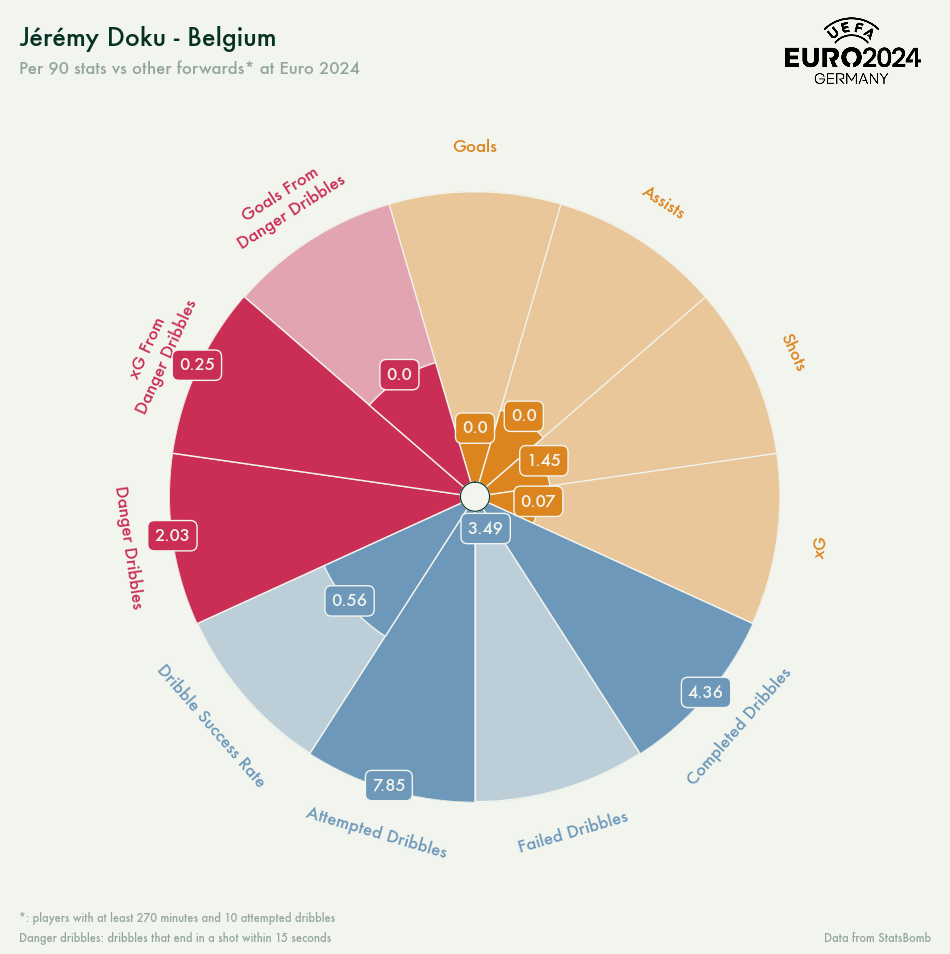

In [ ]:
create_radar_plot(df_player_stats, 23650)